# MODEL INFERENCE NOTEBOOK - CHALLENGE - PART 1 - MULTICLASS CLASSIFICATION

**Author:** Sushmetha S R – VIT Chennai  
**Team Name:** *expendables*  
**Team Members:** Abhinav Chaitanya R, Arjun M, Harshavardhan S, Kiranchandran H, Sushmetha S R  
**Leaderboard Rank:** 73  


# This is the notebook used to display the inferences of the model.

# Importing Libraries

In [25]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from sklearn.metrics import f1_score
import json
import random
import matplotlib.pyplot as plt

# Path Setup

In [ ]:
test_dir = "/kaggle/input/soil-classification/soil_classification-2025/test"
test_ids_path = "/kaggle/input/soil-classification/soil_classification-2025/test_ids.csv"
submission_path = "Submission-expendables.csv"
train_labels_path = "/kaggle/input/soil-classification/soil_classification-2025/train_labels.csv"

train_df = pd.read_csv(train_labels_path)
test_df = pd.read_csv(test_ids_path)

# Data Transformations

In [3]:
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset Loader Class

In [4]:
class SoilDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None, is_test=False):
        self.data_frame = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.is_test = is_test
        self.data_frame['path'] = self.data_frame['image_id'].apply(lambda x: os.path.join(root_dir, x))

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_path = self.data_frame.iloc[idx]['path']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        if self.is_test:
            return image, -1 
        label = self.data_frame.iloc[idx]['soil_type_encoded']
        return image, label

# Inference

In [24]:
test_dataset = SoilDataset(test_df, test_dir, transform=test_transforms, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
label_encoder = LabelEncoder()
label_encoder.fit(train_df['soil_type'])
num_classes = 4

model = models.efficientnet_v2_s(weights=None) 
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(model.classifier[1].in_features, num_classes)
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load('/kaggle/input/best_model_comp1/pytorch/default/1/best_model.pth', map_location=device))
model.to(device)
model.eval()

test_predictions = []
test_confidences = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        probs = torch.softmax(outputs, dim=1)
        test_predictions.extend(predicted.cpu().numpy())
        test_confidences.extend(probs.max(dim=1)[0].cpu().numpy())

test_df['predicted_label'] = test_predictions
test_df['confidence_score'] = test_confidences
test_df['path'] = test_df['image_id'].apply(lambda x: os.path.join(test_dir, x)) 

test_df['soil_type'] = label_encoder.inverse_transform(test_df['predicted_label'])

# Save submission in the required format
submission_df = test_df[['image_id', 'soil_type']]
submission_df.to_csv(submission_path, index=False) 
print(f"Submission saved to {submission_path}")

Submission saved to Submission-new.csv


# Predicting Test Image and Unseen Image

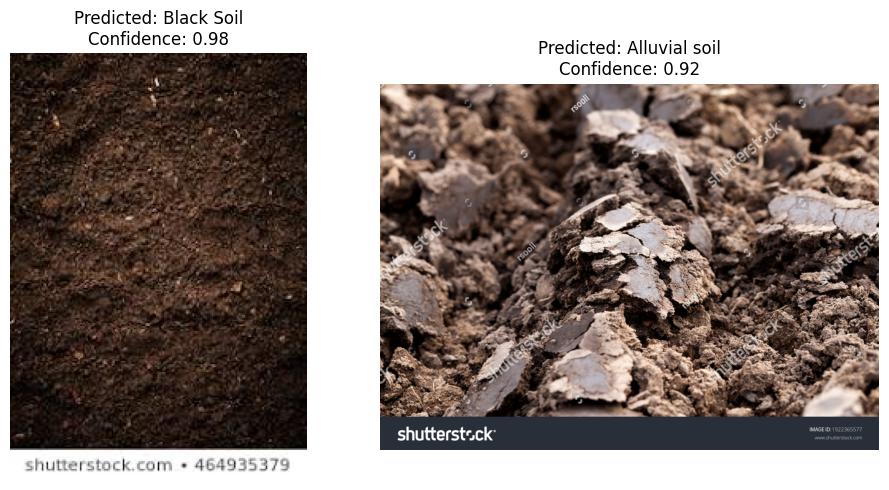

In [32]:
def show_random_predictions(test_df, num_images=2):
    samples = test_df.sample(n=num_images).reset_index(drop=True)

    plt.figure(figsize=(num_images * 5, 5))
    for i in range(num_images):
        img_path = samples.loc[i, 'path']
        img = Image.open(img_path).convert('RGB')

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {samples.loc[i, 'soil_type']}\nConfidence: {samples.loc[i, 'confidence_score']:.2f}")

    plt.tight_layout()
    plt.show()

show_random_predictions(test_df, num_images=2)


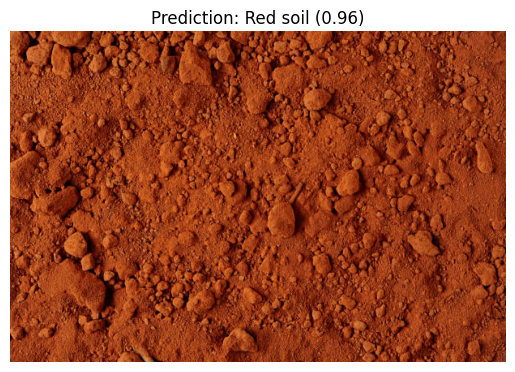

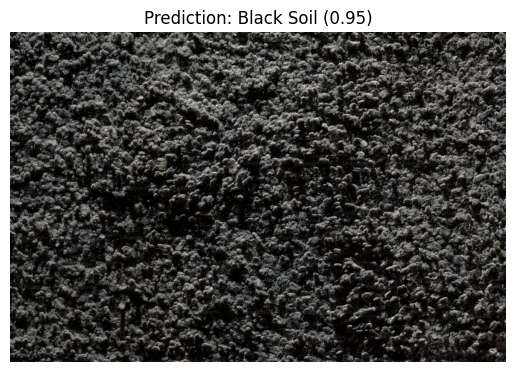

In [33]:
def predict_image(image_path, model, transform, label_encoder):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)  
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1)
        confidence, pred_idx = torch.max(probs, dim=1)
        predicted_label = label_encoder.inverse_transform([pred_idx.cpu().item()])[0]
    return predicted_label, confidence.cpu().item(), image

image_paths = ["/kaggle/input/test-soil-images/soil_test_1.jpg", "/kaggle/input/test-soil-images/soil_test_2.jpg"]

for path in image_paths:
    if os.path.exists(path):
        label, conf, img = predict_image(path, model, test_transforms, label_encoder)
        plt.imshow(img)
        plt.title(f"Prediction: {label} ({conf:.2f})")
        plt.axis("off")
        plt.show()
    else:
        print(f"File not found: {path}")
